# Tutorial 5: Event-Driven Testing

**Goal:** Validate trained policies under realistic timing constraints.

**Time:** ~15 minutes

---

## Why This Matters

You trained a policy in **synchronous mode** (Tutorial 4). But real CPS systems have:

| Real-World Factor | Training Mode | Reality |
|-------------------|---------------|---------|
| Agent tick rates | All same | Devices: 1s, Coordinators: 60s |
| Observation delay | 0ms | 50-2000ms |
| Action delay | 0ms | 100-500ms |
| Timing jitter | None | +/-10-40% |

**HERON's key insight:** You can't test this by wrapping - it requires architectural support.

### Dual Execution Modes

| Mode | Use | Implementation |
|------|-----|----------------|
| **Synchronous** | Training | `env.step(actions)` - all agents step together |
| **Event-Driven** | Testing | `env.run_event_driven()` - agents tick independently |

## The EventScheduler

HERON's `EventScheduler` is a priority-queue based discrete event simulator:

```
EventScheduler
+-- event_queue: [(t=0.0, AGENT_TICK, device_1), 
|                 (t=0.0, AGENT_TICK, device_2),
|                 (t=0.0, AGENT_TICK, coordinator),
|                 ...]
+-- current_time: 0.0
+-- handlers: {agent_id: {AGENT_TICK: handler, ACTION_EFFECT: handler, ...}}
```

Events are processed in timestamp order. When an agent ticks, it:
1. Observes (with `obs_delay`)
2. Computes action
3. Schedules action effect (with `act_delay`)
4. Schedules next tick (with `tick_interval` + optional jitter)

In [17]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from typing import Any, ClassVar, Dict, List, Optional, Sequence
from dataclasses import dataclass, field
from gymnasium.spaces import Box

# HERON imports
from heron.scheduling import EventScheduler, Event, EventType
from heron.scheduling.tick_config import TickConfig, JitterType
from heron.core.feature import FeatureProvider
from heron.core.action import Action
from heron.agents.field_agent import FieldAgent
from heron.agents.coordinator_agent import CoordinatorAgent
from heron.agents.system_agent import SystemAgent
from heron.envs.base import MultiAgentEnv

print("Imports successful!")

Imports successful!


## Step 1: Understanding TickConfig

Each agent has a `TickConfig` that defines its timing parameters:

In [18]:
# Deterministic config (for training - no randomness)
training_config = TickConfig.deterministic(
    tick_interval=1.0,   # Agent ticks every 1 second
    obs_delay=0.0,       # Instant observations
    act_delay=0.0,       # Instant action effects
    msg_delay=0.0,       # Instant messages
)

print("Training config (deterministic):")
print(f"  tick_interval: {training_config.get_tick_interval():.3f}s")
print(f"  obs_delay: {training_config.get_obs_delay():.3f}s")
print(f"  act_delay: {training_config.get_act_delay():.3f}s")

# Testing config with jitter (realistic timing)
testing_config = TickConfig.with_jitter(
    tick_interval=1.0,   # Base interval
    obs_delay=0.1,       # 100ms observation delay
    act_delay=0.2,       # 200ms action delay
    msg_delay=0.05,      # 50ms message delay
    jitter_type=JitterType.GAUSSIAN,  # Gaussian noise
    jitter_ratio=0.1,    # 10% standard deviation
    seed=42,             # Reproducible randomness
)

print("\nTesting config (with 10% Gaussian jitter):")
for i in range(5):
    print(f"  Sample {i+1}: tick={testing_config.get_tick_interval():.3f}s, "
          f"obs={testing_config.get_obs_delay():.3f}s, "
          f"act={testing_config.get_act_delay():.3f}s")

Training config (deterministic):
  tick_interval: 1.000s
  obs_delay: 0.000s
  act_delay: 0.000s

Testing config (with 10% Gaussian jitter):
  Sample 1: tick=1.030s, obs=0.090s, act=0.215s
  Sample 2: tick=1.094s, obs=0.080s, act=0.174s
  Sample 3: tick=1.013s, obs=0.097s, act=0.200s
  Sample 4: tick=0.915s, obs=0.109s, act=0.216s
  Sample 5: tick=1.007s, obs=0.111s, act=0.209s


## Step 2: Define Agents with Timing Configuration

Each agent has timing attributes via `tick_config`:

In [19]:
# Features (using current API with ClassVar visibility)
@dataclass(slots=True)
class BatterySOC(FeatureProvider):
    """Battery state of charge."""
    visibility: ClassVar[Sequence[str]] = ['owner', 'upper_level']
    soc: float = 0.5
    capacity: float = 2.0


@dataclass(slots=True)
class SystemFrequency(FeatureProvider):
    """System frequency."""
    visibility: ClassVar[Sequence[str]] = ['system']
    frequency_hz: float = 60.0


class TimedBattery(FieldAgent):
    """Battery with configurable timing parameters."""
    
    def __init__(
        self, 
        agent_id: str,
        tick_interval: float = 1.0,
        obs_delay: float = 0.0,
        act_delay: float = 0.0,
        use_jitter: bool = False,
        **kwargs
    ):
        self.max_power = 0.5
        
        # Create tick_config based on mode
        if use_jitter:
            tick_config = TickConfig.with_jitter(
                tick_interval=tick_interval,
                obs_delay=obs_delay,
                act_delay=act_delay,
                jitter_type=JitterType.GAUSSIAN,
                jitter_ratio=0.1,
                seed=42,
            )
        else:
            tick_config = TickConfig.deterministic(
                tick_interval=tick_interval,
                obs_delay=obs_delay,
                act_delay=act_delay,
            )
        
        features = [BatterySOC(soc=0.5, capacity=2.0)]
        super().__init__(
            agent_id=agent_id,
            features=features,
            tick_config=tick_config,
            **kwargs
        )

    def init_action(self, features: List[FeatureProvider] = []) -> Action:
        action = Action()
        action.set_specs(dim_c=1, range=(np.array([-1.0]), np.array([1.0])))
        return action

    def set_action(self, action: Any, *args, **kwargs) -> None:
        # Action.set_values expects a 1D array for continuous actions (dim_c > 0)
        arr = np.atleast_1d(np.asarray(action, dtype=np.float32))[:1]
        self.action.set_values(arr)

    def set_state(self, **kwargs) -> None:
        if 'soc' in kwargs:
            self.state.features['BatterySOC'].soc = np.clip(float(kwargs['soc']), 0.1, 0.9)

    def apply_action(self) -> None:
        soc_feature = self.state.features['BatterySOC']
        power = self.action.vector()[0] * self.max_power
        new_soc = soc_feature.soc + power / soc_feature.capacity
        self.set_state(soc=new_soc)

    def compute_local_reward(self, local_state: dict) -> float:
        # local_state from proxy: {feature_name: feature_vector (np.ndarray)}
        # BatterySOC vector = [soc, capacity]
        soc_vec = local_state.get('BatterySOC', np.array([0.5, 2.0]))
        soc = float(soc_vec[0])
        return -abs(0.5 - soc)

    @property
    def soc(self) -> float:
        return self.state.features['BatterySOC'].soc


print("TimedBattery agent defined with configurable timing!")

TimedBattery agent defined with configurable timing!


In [20]:
# Create agents with different timing configurations
# Device-level: fast updates (1s), some delay
fast_battery = TimedBattery(
    agent_id='battery_fast',
    tick_interval=1.0,
    obs_delay=0.05,
    act_delay=0.1,
    use_jitter=True,
)

# Coordinator-level: slower updates (5s), more delay
slow_battery = TimedBattery(
    agent_id='battery_slow',
    tick_interval=5.0,
    obs_delay=0.2,
    act_delay=0.5,
    use_jitter=True,
)

print(f"Fast battery tick config: {fast_battery.tick_config}")
print(f"Slow battery tick config: {slow_battery.tick_config}")

Fast battery tick config: TickConfig(tick_interval=1.0, obs_delay=0.05, act_delay=0.1, msg_delay=0.0, jitter_type=<JitterType.GAUSSIAN: 'gaussian'>, jitter_ratio=0.1, min_delay=0.0)
Slow battery tick config: TickConfig(tick_interval=5.0, obs_delay=0.2, act_delay=0.5, msg_delay=0.0, jitter_type=<JitterType.GAUSSIAN: 'gaussian'>, jitter_ratio=0.1, min_delay=0.0)


## Step 3: Environment with Event-Driven Execution

HERON's `MultiAgentEnv` provides built-in event-driven execution via `run_event_driven()`:

In [21]:
from heron.scheduling import EventAnalyzer, EpisodeResult


@dataclass
class SimpleEnvState:
    """Environment state."""
    battery_soc: Dict[str, float] = field(default_factory=dict)
    frequency: float = 60.0


class SimpleMicrogrid(CoordinatorAgent):
    """Simple coordinator.
    
    tick_interval controls how soon this agent ticks after being
    scheduled by its parent (SystemAgent).  We use 2s here so 
    coordinator events appear quickly in the tutorial timeline.
    """
    
    def __init__(self, agent_id: str, subordinates: Dict[str, TimedBattery], **kwargs):
        super().__init__(
            agent_id=agent_id,
            subordinates=subordinates,
            tick_config=TickConfig.deterministic(tick_interval=2.0),
            **kwargs
        )


class SimpleSystem(SystemAgent):
    """Simple system agent.
    
    Note: No agent_id parameter — SystemAgent defaults to SYSTEM_AGENT_ID
    which is required by the EventScheduler.
    
    tick_interval=10s means the system agent re-schedules itself every
    ~10s after completing each reward-computation cycle.
    """
    
    def __init__(self, subordinates: Dict[str, SimpleMicrogrid]):
        features = [SystemFrequency(frequency_hz=60.0)]
        super().__init__(
            features=features,
            subordinates=subordinates,
            tick_config=TickConfig.deterministic(tick_interval=10.0),
        )


class DualModeEnvironment(MultiAgentEnv):
    """Environment supporting both synchronous and event-driven modes."""
    
    def __init__(
        self,
        system_agent: SystemAgent,
        max_steps: int = 100,
    ):
        self.max_steps = max_steps
        self._step_count = 0
        
        super().__init__(
            system_agent=system_agent,
            env_id="dual_mode_env",
            # simulation_wait_interval controls the delay between the
            # SystemAgent tick and when the physics simulation fires.
            # Setting it to 0.5s means simulation runs shortly after
            # the system tick, before coordinator/field agent ticks.
            simulation_wait_interval=0.5,
        )

    def global_state_to_env_state(self, global_state: Dict) -> SimpleEnvState:
        env_state = SimpleEnvState()
        agent_states = global_state.get("agent_states", {})
        for agent_id, state_dict in agent_states.items():
            features = state_dict.get("features", {})
            if "BatterySOC" in features:
                env_state.battery_soc[agent_id] = features["BatterySOC"].get("soc", 0.5)
        return env_state

    def run_simulation(self, env_state: SimpleEnvState, *args, **kwargs) -> SimpleEnvState:
        avg_soc = np.mean(list(env_state.battery_soc.values())) if env_state.battery_soc else 0.5
        env_state.frequency = 60.0 + (avg_soc - 0.5) * 0.1
        self._step_count += 1
        return env_state

    def env_state_to_global_state(self, env_state: SimpleEnvState) -> Dict:
        agent_states = self.proxy_agent.get_serialized_agent_states()
        for agent_id, state_dict in agent_states.items():
            features = state_dict.get("features", {})
            if "SystemFrequency" in features:
                features["SystemFrequency"]["frequency_hz"] = env_state.frequency
        return {"agent_states": agent_states}

    def reset(self, *, seed: Optional[int] = None, **kwargs):
        self._step_count = 0
        return super().reset(seed=seed, **kwargs)


print("DualModeEnvironment defined!")
print(f"  Coordinator tick_interval: 2.0s  (ticks 2s after system agent)")
print(f"  System tick_interval:      10.0s (re-schedules every ~10s)")
print(f"  Simulation wait:           0.5s  (physics runs 0.5s after system tick)")

DualModeEnvironment defined!
  Coordinator tick_interval: 2.0s  (ticks 2s after system agent)
  System tick_interval:      10.0s (re-schedules every ~10s)
  Simulation wait:           0.5s  (physics runs 0.5s after system tick)


In [22]:
def create_dual_mode_env(use_jitter: bool = False) -> DualModeEnvironment:
    """Create environment with agents."""
    battery_1 = TimedBattery(
        agent_id='battery_1',
        tick_interval=1.0,
        obs_delay=0.05 if use_jitter else 0.0,
        act_delay=0.1 if use_jitter else 0.0,
        use_jitter=use_jitter,
        upstream_id='microgrid',
    )
    battery_2 = TimedBattery(
        agent_id='battery_2',
        tick_interval=1.0,
        obs_delay=0.05 if use_jitter else 0.0,
        act_delay=0.1 if use_jitter else 0.0,
        use_jitter=use_jitter,
        upstream_id='microgrid',
    )
    
    microgrid = SimpleMicrogrid(
        agent_id='microgrid',
        subordinates={'battery_1': battery_1, 'battery_2': battery_2},
        upstream_id='system_agent',
    )
    
    # Note: SystemAgent defaults agent_id to SYSTEM_AGENT_ID ("system_agent")
    system = SimpleSystem(subordinates={'microgrid': microgrid})
    
    return DualModeEnvironment(
        system_agent=system,
        max_steps=100,
    )


test_env = create_dual_mode_env(use_jitter=False)
print(f"Created environment with agents: {list(test_env.registered_agents.keys())}")

Created environment with agents: ['system_agent', 'microgrid', 'battery_1', 'battery_2', 'proxy_agent']


## Step 4: Event-Driven Execution with EventAnalyzer

HERON provides `run_event_driven()` for event-driven simulation with analysis.

### Understanding the Tick Cascade

In event-driven mode, only the **SystemAgent** gets an initial tick. Events then cascade downward through the hierarchy:

```
t=0.0   SystemAgent ticks → schedules CoordinatorAgent tick (at t+2s)
                           → schedules Simulation (at t+0.5s)
t=0.5   Simulation runs  → message cascade: get state → simulate → update → compute rewards
                          → SystemAgent reschedules itself (at t+10s)
t=2.0   Coordinator ticks → schedules FieldAgent ticks (at t+1s)
t=3.0   FieldAgents tick  → agents observe and (if they have policies) compute actions
  ...
t≈10.5  SystemAgent ticks again → next cycle begins
```

**Key insight:** Each agent's `tick_interval` controls the delay from when it's *scheduled by its parent* to when it actually ticks — not a fixed period. The system agent is the only agent that reschedules *itself* (after reward computation completes).

In [ ]:
import io
import contextlib
from collections import Counter
from heron.scheduling import EventAnalysis


class SimpleEventAnalyzer(EventAnalyzer):
    """Analyze events during event-driven execution.
    
    Extends the built-in EventAnalyzer to also collect a simple
    event log for visualization.
    """
    
    def __init__(self):
        super().__init__()
        self.events = []
    
    def parse_event(self, event: Event) -> EventAnalysis:
        """Parse and log event."""
        event_info = {
            'timestamp': event.timestamp,
            'agent_id': event.agent_id,
            'event_type': event.event_type.name,
        }
        self.events.append(event_info)
        return super().parse_event(event)


env = create_dual_mode_env(use_jitter=True)
obs, info = env.reset()

print("Running event-driven simulation (t_end=30s)...\n")

analyzer = SimpleEventAnalyzer()

# Suppress verbose debug prints from agent handlers during simulation
with contextlib.redirect_stdout(io.StringIO()):
    result = env.run_event_driven(
        event_analyzer=analyzer,
        t_end=30.0,
        max_events=500,
    )

# --- Summary ---
last_t = analyzer.events[-1]['timestamp'] if analyzer.events else 0
print(f"Processed {len(analyzer.events)} events over {last_t:.1f}s of simulation time\n")

# Events by type
type_counts = Counter(e['event_type'] for e in analyzer.events)
print("Events by type:")
for etype, count in type_counts.most_common():
    print(f"  {etype:20s}  {count}")

# Events by agent
agent_counts = Counter(e['agent_id'] for e in analyzer.events)
print("\nEvents by agent:")
for aid, count in agent_counts.most_common():
    print(f"  {aid:20s}  {count}")

# Show the first cycle to illustrate the cascade
print("\n--- First cycle (showing the tick cascade) ---")
for event in analyzer.events[:20]:
    print(f"  t={event['timestamp']:7.3f}s | {event['agent_id']:15s} | {event['event_type']}")

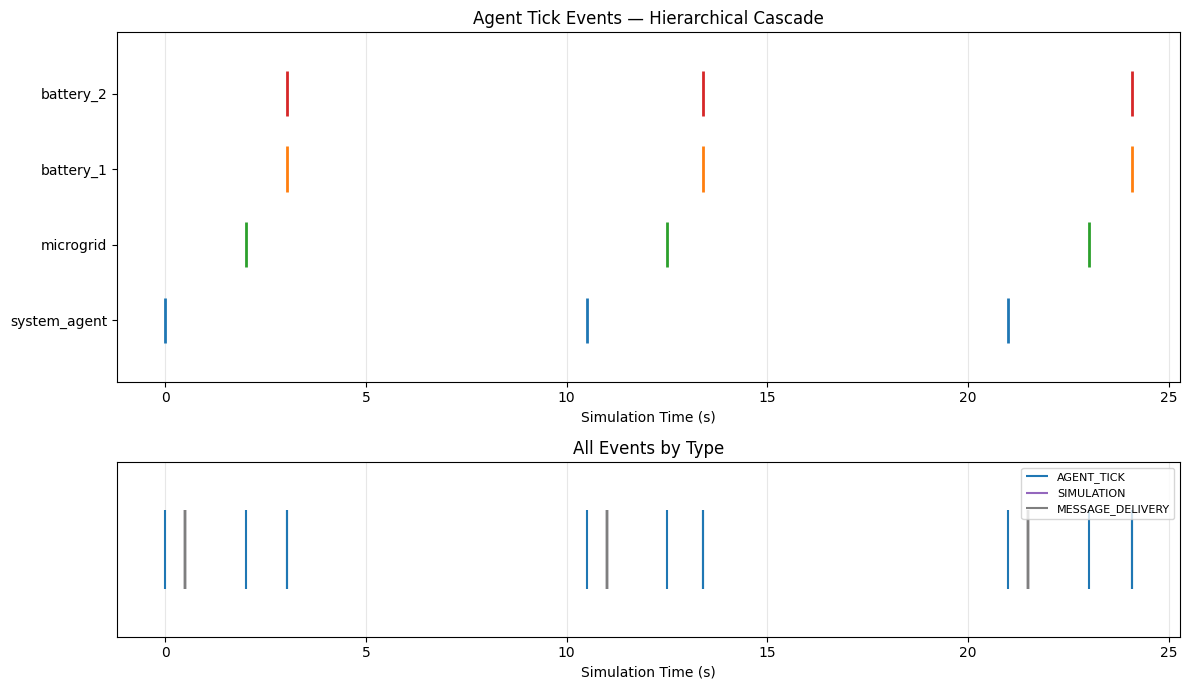

Agent tick counts:
  system_agent   : 3 ticks, avg interval = 10.5s
  microgrid      : 3 ticks, avg interval = 10.5s
  battery_1      : 3 ticks, avg interval = 10.5s
  battery_2      : 3 ticks, avg interval = 10.5s


In [24]:
import matplotlib.pyplot as plt

# --- Plot 1: Agent tick timeline ---
agent_ticks = {}
for event in analyzer.events:
    if event['event_type'] == 'AGENT_TICK':
        aid = event['agent_id']
        agent_ticks.setdefault(aid, []).append(event['timestamp'])

fig, axes = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [2, 1]})

# Top: tick events per agent
colors_map = {
    'system_agent': 'tab:blue',
    'microgrid': 'tab:green',
    'battery_1': 'tab:orange',
    'battery_2': 'tab:red',
}
y_pos = 1
yticks, ylabels = [], []
for aid in ['system_agent', 'microgrid', 'battery_1', 'battery_2']:
    ticks = agent_ticks.get(aid, [])
    if ticks:
        axes[0].eventplot(
            [ticks], lineoffsets=[y_pos], linelengths=0.6,
            colors=[colors_map.get(aid, 'gray')], linewidths=2,
        )
        yticks.append(y_pos)
        ylabels.append(aid)
        y_pos += 1

axes[0].set_yticks(yticks)
axes[0].set_yticklabels(ylabels)
axes[0].set_xlabel('Simulation Time (s)')
axes[0].set_title('Agent Tick Events — Hierarchical Cascade')
axes[0].grid(True, alpha=0.3, axis='x')

# Bottom: all events colored by type
type_colors = {
    'AGENT_TICK': 'tab:blue',
    'SIMULATION': 'tab:purple',
    'MESSAGE_DELIVERY': 'tab:gray',
    'ACTION_EFFECT': 'tab:red',
}
for etype in ['AGENT_TICK', 'SIMULATION', 'MESSAGE_DELIVERY', 'ACTION_EFFECT']:
    times = [e['timestamp'] for e in analyzer.events if e['event_type'] == etype]
    if times:
        axes[1].eventplot(
            [times], lineoffsets=[0], linelengths=0.4,
            colors=[type_colors.get(etype, 'black')], linewidths=1.5,
            label=etype,
        )

axes[1].legend(loc='upper right', fontsize=8)
axes[1].set_yticks([])
axes[1].set_xlabel('Simulation Time (s)')
axes[1].set_title('All Events by Type')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print tick counts
print("Agent tick counts:")
for aid in ['system_agent', 'microgrid', 'battery_1', 'battery_2']:
    ticks = agent_ticks.get(aid, [])
    intervals = [ticks[i+1] - ticks[i] for i in range(len(ticks)-1)]
    avg_interval = np.mean(intervals) if intervals else 0
    print(f"  {aid:15s}: {len(ticks)} ticks"
          + (f", avg interval = {avg_interval:.1f}s" if intervals else ""))

## Step 5: Compare Synchronous vs Event-Driven

Let's run the same policy in synchronous mode with and without timing jitter, then compare results. 

In **synchronous mode**, all agents step together via `env.step(actions)`. In **event-driven mode** (Step 4 above), agents tick independently according to their `TickConfig`.

In [25]:
def run_synchronous_episode(env, policy_fn, max_steps=50, initial_soc=0.3):
    """Run episode in synchronous mode.
    
    We pre-set actions on field agents before calling env.step()
    so that apply_action() uses the correct values during the
    hierarchical execution cycle.
    """
    obs, _ = env.reset()
    
    field_agent_ids = [
        aid for aid, agent in env.registered_agents.items()
        if isinstance(agent, FieldAgent)
    ]

    # Set non-trivial initial SOC so the policy has work to do
    for aid in field_agent_ids:
        agent = env.registered_agents[aid]
        agent.set_state(soc=initial_soc)
        env.proxy_agent.set_local_state(aid, agent.state)

    soc_history = {aid: [initial_soc] for aid in field_agent_ids}
    total_reward = 0
    
    for step in range(max_steps):
        actions = {}
        for aid in field_agent_ids:
            agent = env.registered_agents[aid]
            obs_array = np.array([agent.soc], dtype=np.float32)
            action = policy_fn(obs_array)
            agent.set_action(action)   # pre-set so apply_action() uses it
            actions[aid] = action
        
        with contextlib.redirect_stdout(io.StringIO()):
            obs, rewards, terminateds, truncateds, infos = env.step(actions)
        
        for aid in field_agent_ids:
            agent = env.registered_agents[aid]
            soc_history[aid].append(agent.soc)
        
        total_reward += sum(rewards.values())
        
        if terminateds.get('__all__', False):
            break
    
    return total_reward, soc_history


def simple_policy(obs):
    """Bang-bang policy: charge if SOC < 0.45, discharge if SOC > 0.55."""
    soc = obs[0]
    if soc < 0.45:
        return np.array([0.5])
    elif soc > 0.55:
        return np.array([-0.5])
    return np.array([0.0])


# Start batteries at SOC=0.3 so the policy actively charges them toward 0.5
sync_env = create_dual_mode_env(use_jitter=False)
sync_reward, sync_history = run_synchronous_episode(
    sync_env, simple_policy, max_steps=50, initial_soc=0.3)
print(f"Synchronous (no jitter):   reward = {sync_reward:.2f}")

jitter_env = create_dual_mode_env(use_jitter=True)
jitter_reward, jitter_history = run_synchronous_episode(
    jitter_env, simple_policy, max_steps=50, initial_soc=0.3)
print(f"Synchronous (with jitter): reward = {jitter_reward:.2f}")

print(f"\nNote: In synchronous mode, timing jitter doesn't affect execution")
print(f"(all agents step together). The gap only appears in event-driven mode")
print(f"where agents tick at different rates with realistic delays.")

Synchronous (no jitter):   reward = -6.25
Synchronous (with jitter): reward = -6.25

Note: In synchronous mode, timing jitter doesn't affect execution
(all agents step together). The gap only appears in event-driven mode
where agents tick at different rates with realistic delays.


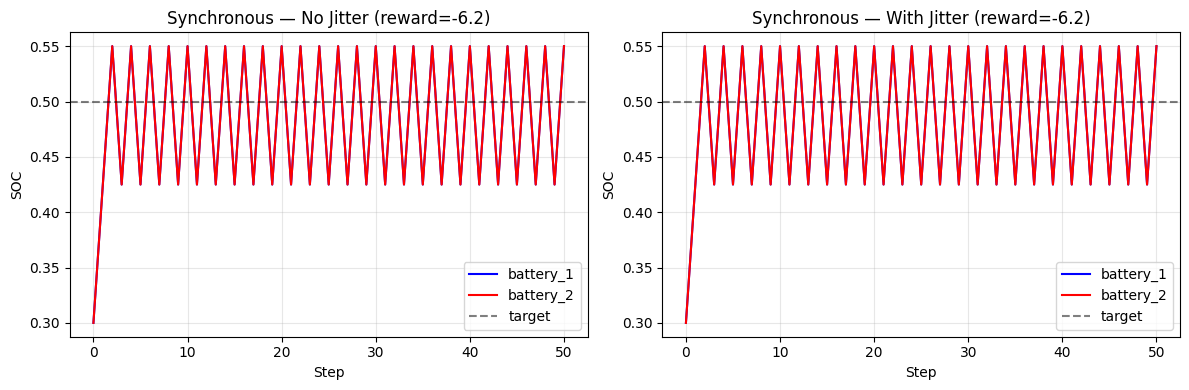

Both plots should look identical — synchronous mode ignores timing jitter.
Event-driven mode (Step 4) is where timing differences actually matter.


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['b', 'r', 'g', 'orange']
for i, (aid, history) in enumerate(sync_history.items()):
    axes[0].plot(history, f'{colors[i % len(colors)]}-', label=aid)
axes[0].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='target')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('SOC')
axes[0].set_title(f'Synchronous — No Jitter (reward={sync_reward:.1f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i, (aid, history) in enumerate(jitter_history.items()):
    axes[1].plot(history, f'{colors[i % len(colors)]}-', label=aid)
axes[1].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='target')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('SOC')
axes[1].set_title(f'Synchronous — With Jitter (reward={jitter_reward:.1f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Both plots should look identical — synchronous mode ignores timing jitter.")
print("Event-driven mode (Step 4) is where timing differences actually matter.")

## Step 6: CPS-Calibrated Timing Configurations

For realistic testing, use timing distributions from real CPS standards:

In [27]:
# SCADA-style: slow updates with high jitter (supervisory control)
scada_timing = TickConfig.with_jitter(
    tick_interval=60.0,
    obs_delay=2.0,
    act_delay=1.5,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.4,
    seed=42,
)

# Fast device-level: rapid sensing with moderate jitter
device_timing = TickConfig.with_jitter(
    tick_interval=1.0,
    obs_delay=0.05,
    act_delay=0.2,
    jitter_type=JitterType.UNIFORM,
    jitter_ratio=0.2,
    seed=42,
)

print("CPS-Calibrated Timing Configurations:")
print(f"\nSCADA (IEEE 2030) - Coordinator level:")
print(f"  base tick_interval: {scada_timing.tick_interval}s")
print(f"  base obs_delay:     {scada_timing.obs_delay}s")
print(f"  Sample intervals:   {[f'{scada_timing.get_tick_interval():.1f}' for _ in range(3)]}")

print(f"\nDevice level:")
print(f"  base tick_interval: {device_timing.tick_interval}s")
print(f"  base obs_delay:     {device_timing.obs_delay}s")
print(f"  Sample intervals:   {[f'{device_timing.get_tick_interval():.3f}' for _ in range(3)]}")

CPS-Calibrated Timing Configurations:

SCADA (IEEE 2030) - Coordinator level:
  base tick_interval: 60.0s
  base obs_delay:     2.0s
  Sample intervals:   ['67.3', '35.0', '78.0']

Device level:
  base tick_interval: 1.0s
  base obs_delay:     0.05s
  Sample intervals:   ['1.110', '0.976', '1.143']


## Key Takeaways

### HERON Event-Driven Features

1. **TickConfig**: Agent-level timing configuration
   ```python
   tick_config = TickConfig.with_jitter(
       tick_interval=1.0,
       obs_delay=0.1,
       act_delay=0.2,
       jitter_type=JitterType.GAUSSIAN,
       jitter_ratio=0.1,
   )
   ```

2. **EventScheduler**: Priority-queue based discrete event simulation
   ```python
   env.run_event_driven(
       event_analyzer=analyzer,
       t_end=10.0,
   )
   ```

3. **Heterogeneous Timing**: Different agents can have different tick rates

### The Testing Workflow

```
1. Train in synchronous mode (fast, deterministic)
       |
2. Test with timing jitter (realistic uncertainty)
       |
3. Test in full event-driven mode (heterogeneous timing)
       |
4. If performance degrades -> retrain with timing awareness
```

### HERON Timing Parameters

| Parameter | Meaning | Example |
|-----------|---------|--------|
| `tick_interval` | How often agent acts | Device: 1s, Coord: 60s |
| `obs_delay` | Sensor latency | 50ms - 2s |
| `act_delay` | Actuator latency | 100ms - 500ms |
| `msg_delay` | Communication latency | 10ms - 200ms |
| `jitter_ratio` | Timing variance | 10-40% |

---

**Next:** [06_configuration_and_datasets.ipynb](06_configuration_and_datasets.ipynb) - YAML configs and datasets